## Document Retrieval using TF-IDF and Ranking using Scoring / Matching Score and Cosine Similarity

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words


import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import re
import math
import matplotlib.pyplot as plt
import plotly.express as px
from statistics import mean


In [2]:
alpha = 0.3

## Loading the data from archive and creating dataset
The dataset we are going to use are archives of textfiles, this dataset has lots of documents in different formats.

Dataset Link: http://archives.textfiles.com/

We are using the "stories"

In [3]:
title = "data"
folders = [x[0] for x in os.walk(str(os.getcwd())+'/'+title+'/')]
folders[0] = folders[0][:len(folders[0])-1]

#### Collecting the file paths and titles 

In [4]:
dataset = []

c = False

for i in folders:
        # print("Folder : ",i)
        file = open(i+"/index.html", 'r')
        text = file.read()
        file.close()

        file_name = re.findall('><A HREF="(.*)">', text)
        file_title = re.findall('<BR><TD> (.*)\n', text)

        if c == False:
            file_name = file_name[2:]
            c = True
        
        print("Folder : ",i , " | Total files  : ",len(file_name))
        # print(len(file_name), len(file_title))
        
       
        for j in range(len(file_name)):
            dataset.append((str(i) +"/"+ str(file_name[j]), file_title[j]))

   

Folder :  c:\Users\kk910\OneDrive\Desktop\IR/data  | Total files  :  452
Folder :  c:\Users\kk910\OneDrive\Desktop\IR/data/FARNON  | Total files  :  0
Folder :  c:\Users\kk910\OneDrive\Desktop\IR/data/SRE  | Total files  :  15


In [5]:
def print_doc(id):
    # print(dataset[id])
    file = open(dataset[id][0], 'r', encoding='cp1250')
    text = file.read().strip()
    file.close()
    print("No of Words ", len(text.split()))
    print("")
    print(text)

In [6]:
N = len (dataset)
print("Total files in datset : ",N)
print("")

print("400th file : ",dataset[400])
print_doc(400)

Total files in datset :  467

400th file :  ('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/sucker.txt', 'The Dark Sucker, by Quantum Mechanic')
No of Words  655

D A R K  S U C K E R .

              Rewritten by the Quantum Mechanic

     For years it has been believed that electric bulbs emitted light.
However, recent information has proven otherwise. Electric bulbs don't 
emit light, they suck dark. Thus we call these bulbs dark suckers. The
dark sucker theory proves that the existence of dark has mass heavier
than that of light, and that dark is faster than light.

The basis of the dark sucker theory is that electric bulbs suck dark.
Take, for example, the dark suckers in the room where you are. There is
much less dark right next to them than there is elsewhere. The larger the
dark sucker, the greater its capacity to suck dark. Dark suckers in a
parking lot have a much greater capacity than the ones in this room. As
with all things, dark suckers don't last forever. Once they are fu

# Preprocessing
- convert_lower_case(data)
- remove_punctuation(data)
- remove_apostrophe(data)
- remove_stop_words(data)
- convert_numbers(data)
- stemming(data)
    

In [7]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text


def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

## Preprocessing title and body text

In [8]:
processed_text = []
processed_title = []

for i in dataset[:N]:
    print(i)
    file = open(i[0], 'r', encoding="utf8", errors='ignore')
    text = file.read().strip()
    file.close()

    processed_text.append(word_tokenize(str(preprocess(text))))
    processed_title.append(word_tokenize(str(preprocess(i[1]))))

('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/100west.txt', 'Going 100 West by 53 North by Jim Prentice (1990)')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/13chil.txt', 'The Story of the Sly Fox')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/14.lws', 'A Smart Bomb with a Language Parser')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/16.lws', 'Two Guys in a Garage, by M. Pshota')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/17.lws', 'The Early Days of a High-Tech Start-up are Magic (November 18, 1991) by M. Peshota')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/18.lws', 'The Couch, the File Cabinet, and the Calendar, by M. Peshota (December 9, 1991)')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/19.lws', 'Engineering the Future of American Technology by M. Peshota (January 5, 1992)')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/20.lws', 'What Research and Development Was Always Meant to Be, by M. Peshota')
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/3gables.txt', 'Th

In [9]:
print(len(processed_text))
print(len(processed_title))

z=60
print(dataset[z])
# print(processed_text[z])
print(processed_title[z])

467
467
('c:\\Users\\kk910\\OneDrive\\Desktop\\IR/data/blabnove.txt', 'Super Blabnovel-A continuing saga on DATANET')
['super', 'blabnovel', 'continu', 'saga', 'datanet']


## Calculating DF for all words

In [10]:
DF = {}

for i in range(N):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

    tokens = processed_title[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
for i in DF:
    DF[i] = len(DF[i])



total_vocab = [x for x in DF]
# print(total_vocab[:20])
print("Total Vocab Size : ",len(total_vocab))

Total Vocab Size :  32350


In [11]:
DF

{'sharewar': 5,
 'trial': 35,
 'project': 63,
 'freewar': 1,
 'need': 243,
 'support': 87,
 'continu': 193,
 'one': 444,
 'hundr': 329,
 'west': 65,
 'fifti': 160,
 'three': 293,
 'north': 73,
 'jim': 20,
 'prentic': 3,
 'copyright': 115,
 'thousand': 314,
 'nine': 284,
 'nineti': 215,
 'brandon': 3,
 'manitoba': 2,
 'canada': 10,
 'magic': 89,
 'phrase': 40,
 'spoken': 42,
 'mumbl': 45,
 'thought': 323,
 'inwardli': 8,
 'soul': 104,
 'ventur': 57,
 'northward': 7,
 'imaginari': 20,
 'line': 186,
 'shown': 64,
 'map': 48,
 'label': 22,
 'degr': 56,
 'presenc': 83,
 'indic': 74,
 'highway': 35,
 'travel': 109,
 'road': 119,
 'side': 243,
 'sign': 151,
 'divi': 29,
 'territori': 21,
 'distinct': 41,
 'mind': 234,
 'intern': 50,
 'border': 37,
 'writer': 55,
 'poet': 17,
 'pilot': 36,
 'contribut': 31,
 'lore': 6,
 'rigor': 6,
 'life': 274,
 'bush': 45,
 'told': 246,
 'tale': 73,
 'man': 271,
 'eat': 139,
 'mosquito': 6,
 'murder': 81,
 'hord': 15,
 'black': 189,
 'fli': 121,
 'lump': 25,

### Calculating TF-IDF for body
- tf = counter[token]/words_count
- idf = np.log((N+1)/(df+1))

#numerator is added 1 to avoid negative values


In [12]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

doc = 0

tf_idf = {}
for i in range(N):
    tokens = processed_text[i]
    counter = Counter(tokens + processed_title[i])
    words_count = len(tokens + processed_title[i])
    for token in np.unique(tokens):
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))
        tf_idf[doc, token] = tf*idf
    doc += 1

In [13]:
tf_idf

{(0, '4x4'): 0.003087335096410697,
 (0, 'abl'): 0.0005283149622573069,
 (0, 'abound'): 0.0018438576898819933,
 (0, 'absenc'): 0.001436078315378281,
 (0, 'access'): 0.001243477406528704,
 (0, 'accustom'): 0.0031095313121171377,
 (0, 'activ'): 0.0018535470168656444,
 (0, 'acut'): 0.001947039102894984,
 (0, 'ad'): 0.00078454689367283,
 (0, 'adapt'): 0.0016579470690715598,
 (0, 'adjust'): 0.0012887760526371001,
 (0, 'adult'): 0.0015547656560585689,
 (0, 'advanc'): 0.0009788498517945947,
 (0, 'adventuresom'): 0.003087335096410697,
 (0, 'afford'): 0.0011915206723730034,
 (0, 'ago'): 0.0005764400571559554,
 (0, 'aid'): 0.0010515047282225556,
 (0, 'air'): 0.0009679269623012499,
 (0, 'aircraft'): 0.0268335736406209,
 (0, 'airplan'): 0.0022361311367184084,
 (0, 'airport'): 0.007253037502549421,
 (0, 'airstrip'): 0.003087335096410697,
 (0, 'allow'): 0.0007205834593754925,
 (0, 'alright'): 0.0015362088802674027,
 (0, 'also'): 0.0009343048294049106,
 (0, 'although'): 0.0016702201035152697,
 (0, 'al

### Calculating TF-IDF for Title

In [14]:
doc = 0

tf_idf_title = {}

for i in range(N):
    
    tokens = processed_title[i]
    counter = Counter(tokens + processed_text[i])
    words_count = len(tokens + processed_text[i])

    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1)) 
        
        tf_idf_title[doc, token] = tf*idf

    doc += 1

In [15]:
tf_idf_title

{(0, 'fifti'): 0.005434960598980563,
 (0, 'go'): 0.0002906893990853149,
 (0, 'hundr'): 0.002570392381970895,
 (0, 'jim'): 0.005269857144642146,
 (0, 'nine'): 0.0008420698058556812,
 (0, 'nineti'): 0.001312716278834434,
 (0, 'north'): 0.021919902239379185,
 (0, 'one'): 0.0003992734536048051,
 (0, 'prentic'): 0.008085184948722846,
 (0, 'thousand'): 0.0008961984314476824,
 (0, 'three'): 0.0015785688576535318,
 (0, 'west'): 0.0033256596840258424,
 (1, 'fox'): 0.11198195635330804,
 (1, 'sli'): 0.11239056533822733,
 (1, 'stori'): 0.0007682063585522353,
 (2, 'bomb'): 0.023742982378177565,
 (2, 'languag'): 0.027898190361964424,
 (2, 'parser'): 0.05635662309253824,
 (2, 'smart'): 0.014515325244714838,
 (3, 'garag'): 0.008785324492085607,
 (3, 'guy'): 0.0031995505339385936,
 (3, 'pshota'): 0.004145380786745974,
 (3, 'two'): 0.0018360457195132072,
 (4, 'day'): 0.0008890808368913132,
 (4, 'earli'): 0.0028199293637210404,
 (4, 'eighteen'): 0.0042241724258131105,
 (4, 'high'): 0.006977574311606774,


In [16]:
tf_idf[(0,"two")]

0.0003418557112166639

In [17]:
tf_idf_title[(3,"two")]

0.0018360457195132072


- document = body + title## Merging the TF-IDF of title and body
- TF-IDF(document) = TF-IDF(title) * (1-alpha) + TF-IDF(body) * (alpha)

In [18]:
for i in tf_idf:
    tf_idf[i] *= alpha

for i in tf_idf_title:
    tf_idf[i] = tf_idf_title[i]

In [19]:
len(tf_idf)

344378

In [20]:
def get_doc(id):
    # print(dataset[id])
    file = open(dataset[id][0], 'r', encoding='ISO-8859-1')
    text = file.read().strip()
    file.close()
    return text


# REFERENCE : Query
# HYPOTHESIS  : Resukt generated from TFIDF
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, 
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)][score_entry]

      return rouge_score

In [21]:
def plot_pr(recall,precision,method):
    
    plt.scatter(recall, precision, c='r')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Scatter Plot for '+ str(method))
    plt.show()

    fig = px.scatter(x=recall, y=precision, labels={'x':'recall', 'y':'precision'},trendline="lowess",trendline_options=dict(frac=0.1),title="Precision-Recall TrendLine " + str(method))
    # fig.show()

    
    fig.data = [t for t in fig.data if t.mode == "lines"]
    fig.update_traces(showlegend=False) #trendlines have showlegend=False by default
    fig.show()      


    

#  Ranking - Matching Score : 
In this method, we add tf_idf values of the tokens that are in query for every document.

We need to check in every document if these query_tokens exist and if the word exists, then the tf_idf value is added to the matching score of that particular doc_id. 

In the end, we will sort and take the top k documents.

- Preprocess the query and get query_tokens
- Traverse all keys in tf_idf . If match with query_tokens , add to the query_weights dictionary
- Top 10 doc_id


Matching Score


Query: One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.
Tokens: 36
429 c:\Users\kk910\OneDrive\Desktop\IR/data/vaincrow.txt | Matching Score  0.4
186 c:\Users\kk910\OneDrive\Desktop\IR/data/foxncrow.txt | Matching Score  0.21
405 c:\Users\kk910\OneDrive\Desktop\IR/data/tailbear.txt | Matching Score  0.1
339 c:\Users\kk910\OneDrive\Desktop\IR/data/quarter.c11 | Matching Score  0.08
351 c:\Users\kk910\OneDrive\Desktop\IR/data/quarter.c5 | Matching Score  0.05
416 c:\Users\kk910\OneDrive\Desktop\IR/data/the-tree.txt | Matching Score  0.03
291 c:\Users\kk910\OneDrive\Desktop\IR/data/musibrem.txt | Matching Score  0.02
176 c:\Users\kk910\OneDrive\Desktop\IR/d

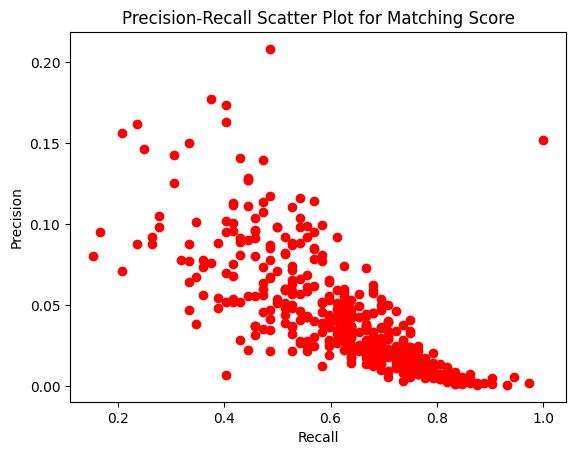

In [22]:
def matching_score(k, query):
    preprocessed_query = preprocess(query)
    query_tokens = word_tokenize(str(preprocessed_query))

    print("Matching Score")
    print("")
    print("\nQuery:", query)
    print("Tokens:", len(query_tokens))
    # print(query_tokens)
    # print("")
    
    query_weights = {}

    for key in tf_idf:
        
        if key[1] in query_tokens:
            try:
                query_weights[key[0]] += tf_idf[key]
            except:
                query_weights[key[0]] = tf_idf[key]
    
    query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)

    # print("")
    top = []
    all_top=[]

    # Top 10 doc_id
    for i in query_weights[:10]:
        top.append(i[0])

    # All doc_id in ranked order
    for i in query_weights:
        all_top.append(i[0])

    # Doc_id with Score
    queri_weights = {}
    count=0
    for i in query_weights[:10]:
        queri_weights[i[0]]=query_weights[count][1]
        count+=1
    # print(queri_weights)
    
    # print("")

    # print(top)
    
    # Showing top retrieved docs with extra info
    for i in top:
        print(i, dataset[i][0],"| Matching Score ",round(queri_weights.get(i),2))
    

# Precision Recall Calculation using ROUGE
    precision=[]
    recall=[]
    for i in all_top:
        precision.append(rouge_scoring(get_doc(i),query,score='Precision'))
        recall.append(rouge_scoring(get_doc(i),query,score='Recall'))
    # print("Precision",precision)
    # print("Recall",recall)


    # print("Average Precision",mean(precision))
    # print("Average Recall",mean(recall))

    plot_pr(recall,precision,"Matching Score")
    
    

    
matching_score(10, "One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.")

# Ranking - Cosine Similarity 

In [23]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

### Vectorising tf-idf
- Using total_vocab (list of unique tokens) to generate an index for each token, and we will use numpy of size (docs, total_vocab) to store the document vectors

In [24]:
D = np.zeros((N, len(total_vocab)))
for i in tf_idf:
    try:
        ind = total_vocab.index(i[1])
        D[i[0]][ind] = tf_idf[i]
    except:
        pass

row, col = D.shape
print(row,col)

467 32350


 For Query : 
 - TF can calculate from the query_tokens,  
 - DF (already created)
 - Store in a (1,vocab_size) numpy array to store the tf-idf values, index of the token will be decided from the total_vocab list

In [25]:
def gen_vector(tokens):

    Q = np.zeros((len(total_vocab)))
    
    counter = Counter(tokens)
    words_count = len(tokens)

    query_weights = {}
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = math.log((N+1)/(df+1))

        try:
            ind = total_vocab.index(token)
            Q[ind] = tf*idf
        except:
            pass
    return Q

- Preprocess the Query and generate query_tokens
- Create query_vector using query_tokens
- Calculate cosine similarity between query_vector and all document vectors

Cosine Similarity

Query: One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.One day, a Mongol prince seemed to be on the point of winning a smile.
Tokens: 44
429 c:\Users\kk910\OneDrive\Desktop\IR/data/vaincrow.txt | Cosine Similarity 0.49
186 c:\Users\kk910\OneDrive\Desktop\IR/data/foxncrow.txt | Cosine Similarity 0.13
27 c:\Users\kk910\OneDrive\Desktop\IR/data/aesopa10.txt | Cosine Similarity 0.1
229 c:\Users\kk910\OneDrive\Desktop\IR/data/home.fil | Cosine Similarity 0.07
405 c:\Users\kk910\OneDrive\Desktop\IR/data/tailbear.txt | Cosine Similarity 0.06
416 c:\Users\kk910\OneDrive\Desktop\IR/data/the-tree.txt | Cosine Similarity 0.06
339 c:\Users\kk910\OneDrive\Desktop\I

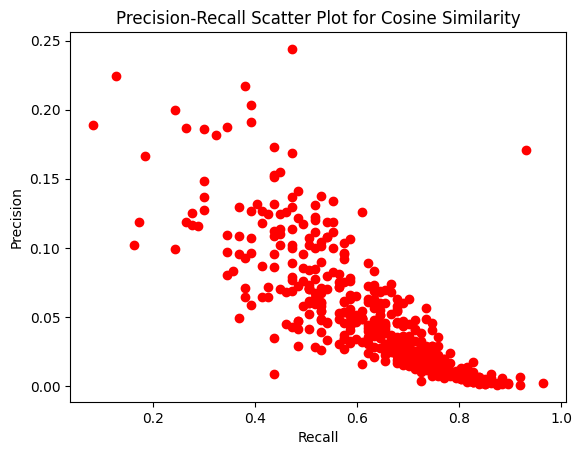

In [26]:
def cosine_similarity(k, query):
    print("Cosine Similarity")
    preprocessed_query = preprocess(query)
    query_tokens = word_tokenize(str(preprocessed_query))
    
    print("\nQuery:", query)
    print("Tokens:", len(query_tokens))
    # print(query_tokens)
    
    d_cosines = []
    
    query_vector = gen_vector(query_tokens)
    
    for d in D:
        d_cosines.append(cosine_sim(query_vector, d))

    # print(d_cosines)

    d_cosines_sorted=sorted(d_cosines)[-k:][::-1]

    # Top k doc_id
    top = np.array(d_cosines).argsort()[-k:][::-1]

    # All doc_id
    top_all = np.array(d_cosines).argsort()
    
    # print(top_all)


    # Storing ranked in a dictionary
    cosine_weights = {}
    count=0
    for i in top:
        cosine_weights[i]=d_cosines_sorted[count]
        count+=1
    
    # print(cosine_weights)
        
    # print("")

    for i in top:
        print(i, dataset[i][0],"| Cosine Similarity",round(cosine_weights[i],2))
    
    
    precision=[]
    recall=[]
    for i in top_all:
        precision.append(rouge_scoring(get_doc(i),query,score='Precision'))
        recall.append(rouge_scoring(get_doc(i),query,score='Recall'))
    # print("Precision",precision)
    # print("Recall",recall)
    
    # print("Average Precision",mean(precision))
    # print("Average Recall",mean(recall))

    plot_pr(recall,precision,"Cosine Similarity")


Q = cosine_similarity(10, "One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.One day, a Mongol prince seemed to be on the point of winning a smile.")

# Mixed Query : doc(429) + doc(439)

- Matching Score shows 429 , 186 , 439 , 400 ,..
- Cosine Similarity shows 429, 439, 382, 186 ,..

Matching Score


Query: One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.One day, a Mongol prince seemed to be on the point of winning a smile. He thrummed his balalaika for hours, playing first a sad tune, then a more cheerful one, till he finished by playing a merry jig. The princess sat for ages staring at him eyed and the onlookers thought she was about to smile.Instead she burst into floods of tears, to everyone's disappointment. A Kurdish chief, famed for his humour, who had already kept the court in fits oflaughter, tried to steal a smile from Sarah with his witty remarks. But the princess's dark eyes filled with tears. Noblemen came from as far away as Persia, but

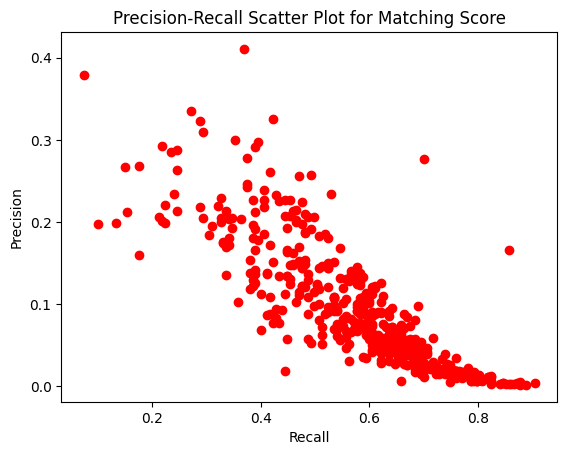

In [27]:
matching_score(10, "One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.One day, a Mongol prince seemed to be on the point of winning a smile. He thrummed his balalaika for hours, playing first a sad tune, then a more cheerful one, till he finished by playing a merry jig. The princess sat for ages staring at him eyed and the onlookers thought she was about to smile.Instead she burst into floods of tears, to everyone's disappointment. A Kurdish chief, famed for his humour, who had already kept the court in fits oflaughter, tried to steal a smile from Sarah with his witty remarks. But the princess's dark eyes filled with tears. Noblemen came from as far away as Persia, but in vain.")


Cosine Similarity

Query: One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.One day, a Mongol prince seemed to be on the point of winning a smile. He thrummed his balalaika for hours, playing first a sad tune, then a more cheerful one, till he finished by playing a merry jig. The princess sat for ages staring at him eyed and the onlookers thought she was about to smile.Instead she burst into floods of tears, to everyone's disappointment. A Kurdish chief, famed for his humour, who had already kept the court in fits oflaughter, tried to steal a smile from Sarah with his witty remarks. But the princess's dark eyes filled with tears. Noblemen came from as far away as Persia, b

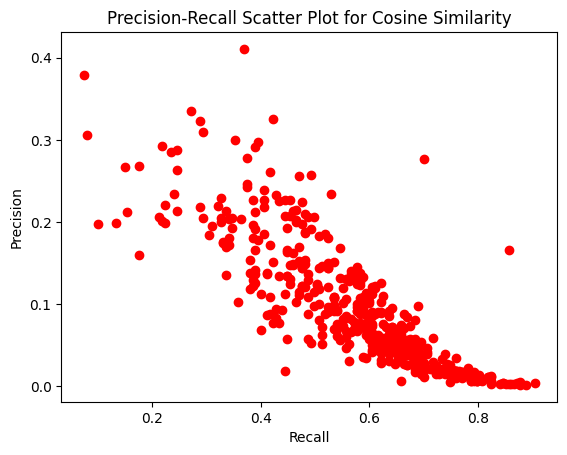

In [28]:
cosine_similarity(10, "One day, he noticed that one of the peacocks had dropped a feather. When the sun went down, the crow picked it up and hid it away. For days on end, he watched the peacocks and found another feather. When he had four, he could wait no longer: he stuck the peacock feathers onto his own tail, using pine resin, and started to parade up and down for his friends to admire.One day, a Mongol prince seemed to be on the point of winning a smile. He thrummed his balalaika for hours, playing first a sad tune, then a more cheerful one, till he finished by playing a merry jig. The princess sat for ages staring at him eyed and the onlookers thought she was about to smile.Instead she burst into floods of tears, to everyone's disappointment. A Kurdish chief, famed for his humour, who had already kept the court in fits oflaughter, tried to steal a smile from Sarah with his witty remarks. But the princess's dark eyes filled with tears. Noblemen came from as far away as Persia, but in vain.")

# Conclusion

- Matching Score gives relevant documents but it quite fails when we give long queries, it will not be able to rank them properly.
- Matching Score computes manhattan distance (straight line from tips) Cosine score considers the angle of the vectors.
- Cosine similarity learns the context more. In every type of query (small , medium , large) cosine similarity ranking is better than matching score ranking.


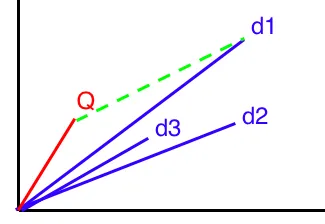

- Matching Score will return document d3 but that is not very closely related.
- Though the manhattan distance (green line) is very high for document d1 but the query is still close to document d1.
- Cosine Similarity will return document d1

- When the query length would be small but it might be closely related to the document in such cases cosine similarity is the best to find relevance.

- TF-IDF is about features and their normalization. Cosine metric is metric that you will use to score.
- TF-IDF will give you a representation for a given term in a document. Cosine similarity will give you a score for two different documents that share the same representation.
